In [1]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
from tensorflow import keras

import utils

plt.rcParams['figure.figsize'] = (25, 8)
plt.rcParams["figure.autolayout"] = True

# Audio to Vec

In [2]:
import tensorflow as tf
import pathlib
import tensorflow_io as tfio

In [3]:
music_root = pathlib.Path('./music_data/')

In [4]:
for item in music_root.glob("*"):
  print(item.name)

In [9]:
list_ds = tf.data.Dataset.list_files(str(music_root/'*/*'))

In [10]:
def parse_chroma(audio_path):
  label = tf.strings.split(audio_path, os.sep)
  label = label[-2].numpy().decode('utf-8')
  x, sr = librosa.load(audio_path.numpy().decode('utf-8'), sr=None, mono=True,offset=0.0, duration=3.0)
  chroma = librosa.feature.chroma_stft(y=x,sr=sr)
  return chroma, label

techno


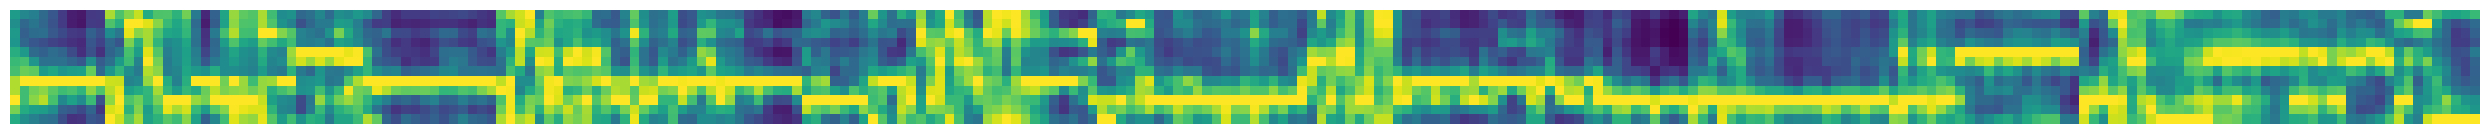

In [11]:
# test function parse_chroma
file_path = next(iter(list_ds))
chroma, label = parse_chroma(file_path)

def show(chroma, label):
  print(label)
  plt.imshow(chroma)
  plt.axis('off')

show(chroma, label)

techno


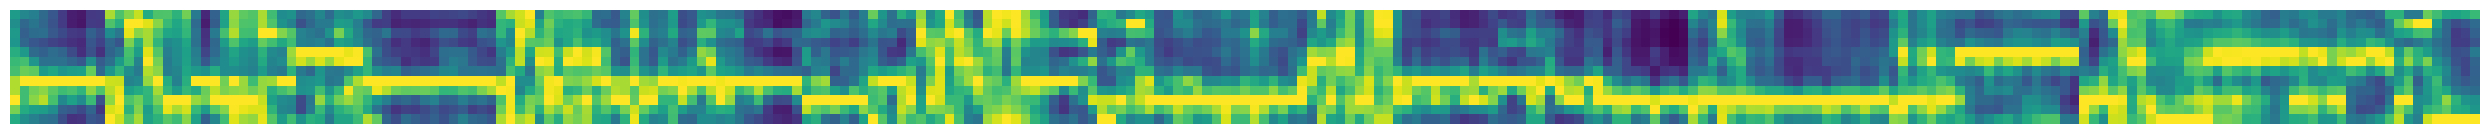

In [12]:
z = map(parse_chroma,[file_path])
q = np.array(list(z), dtype=object)
show(q[0][0], q[0][1])

In [13]:
classes = [item.name for item in music_root.glob("*")]

In [14]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)

In [124]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)

# Build CNN Model

In [15]:
from sklearn.model_selection import train_test_split

In [119]:

def onehot(y_str):
    nclass=len(classes)
    y_num = np.array([classes.index(y) for y in y_str])
    y_ = np.zeros((y_str.shape[0], nclass))
    for i, y in enumerate(y_num):
        y_[i, int(y)] = 1
    return y_

In [81]:
BATCH_FILES: int = 250

In [82]:

# music_root = pathlib.Path('./music_data/')
# list_files = tf.data.Dataset.list_files(str(music_root/'*/*'))
index_batch = 0
iterate = 0
batch_size = int(250/BATCH_FILES)

for iterate in range(1, batch_size+1) :

    x_dataset = []
    y_dataset = []

    for dir in music_root.glob("*"):
        list_files = tf.data.Dataset.list_files(str(dir/'*'))
        list_files = [i for i in list_files]

        index_file = index_batch
        while(index_file < iterate * BATCH_FILES):
            item = list_files[index_file]
            chroma, label = parse_chroma(item)
            x_dataset.append(chroma)
            y_dataset.append(label)
            index_file += 1

    index_batch += BATCH_FILES

    x_dataset = np.array(x_dataset)
    y_dataset = np.array(y_dataset)

    x_dataset = x_dataset.reshape((*x_dataset.shape, 1))
    y_dataset = onehot(y_dataset)

    X_train, X_test, Y_train, Y_test = train_test_split(x_dataset, y_dataset, train_size=0.75, stratify=y_dataset)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, train_size=0.8, stratify=Y_train)

    # CNNmodel.fit(X_train, Y_train, batch_size=10, epochs=20, validation_data=(X_test, Y_test), shuffle=True)
    break


C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\librosa\core\pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [90]:
# save dataset-vec to file

# np.save('./dataset-vec/x.npy', x_dataset)
# np.save('./dataset-vec/y.npy', y_dataset)

In [91]:
# load dataset-vec

x_dataset = np.load('./dataset-vec/x.npy')
y_dataset = np.load('./dataset-vec/y.npy')

In [92]:
X_train, X_test, Y_train, Y_test = train_test_split(x_dataset, y_dataset, train_size=0.75, stratify=y_dataset)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, train_size=0.8, stratify=Y_train)

In [94]:
X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

28250

In [130]:
input_shape=(12, 259, 1)
CNNmodel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(10, (3, 3), activation='relu', padding="same", input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(10, (3, 3), activation='relu'),

    tf.keras.layers.Conv2D(10, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(113, activation='softmax'),
])

CNNmodel.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 12, 259, 10)       100       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 6, 129, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 4, 127, 10)        910       
                                                                 
 conv2d_61 (Conv2D)          (None, 2, 125, 10)        910       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 1, 62, 10)        0         
 g2D)                                                            
                                                                 
 flatten_20 (Flatten)        (None, 620)             

In [131]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=1e-6)

CNNmodel.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [132]:
history = CNNmodel.fit(X_train, Y_train, batch_size=250, epochs=20, validation_data=(X_val, Y_val), shuffle=True)

Epoch 1/20
68/68 [==============================] - 9s 131ms/step - loss: 4.7230 - accuracy: 0.0088 - val_loss: 4.6817 - val_accuracy: 0.0099
Epoch 2/20
68/68 [==============================] - 8s 121ms/step - loss: 4.6465 - accuracy: 0.0162 - val_loss: 4.5656 - val_accuracy: 0.0196
Epoch 3/20
68/68 [==============================] - 8s 121ms/step - loss: 4.5372 - accuracy: 0.0224 - val_loss: 4.4912 - val_accuracy: 0.0293
Epoch 4/20
68/68 [==============================] - 8s 123ms/step - loss: 4.4617 - accuracy: 0.0317 - val_loss: 4.4127 - val_accuracy: 0.0399
Epoch 5/20
68/68 [==============================] - 8s 122ms/step - loss: 4.3799 - accuracy: 0.0414 - val_loss: 4.3479 - val_accuracy: 0.0439
Epoch 6/20
68/68 [==============================] - 8s 122ms/step - loss: 4.2914 - accuracy: 0.0531 - val_loss: 4.2981 - val_accuracy: 0.0514
Epoch 7/20
68/68 [==============================] - 8s 123ms/step - loss: 4.2160 - accuracy: 0.0630 - val_loss: 4.2250 - val_accuracy: 0.0592
Epoch 

In [133]:
CNNmodel.evaluate(X_test, Y_test)

221/221 [==============================] - 1s 6ms/step - loss: 4.3099 - accuracy: 0.1025


[4.309893608093262, 0.10250601917505264]

In [134]:
pred = CNNmodel.predict(X_test)

221/221 [==============================] - 1s 6ms/step


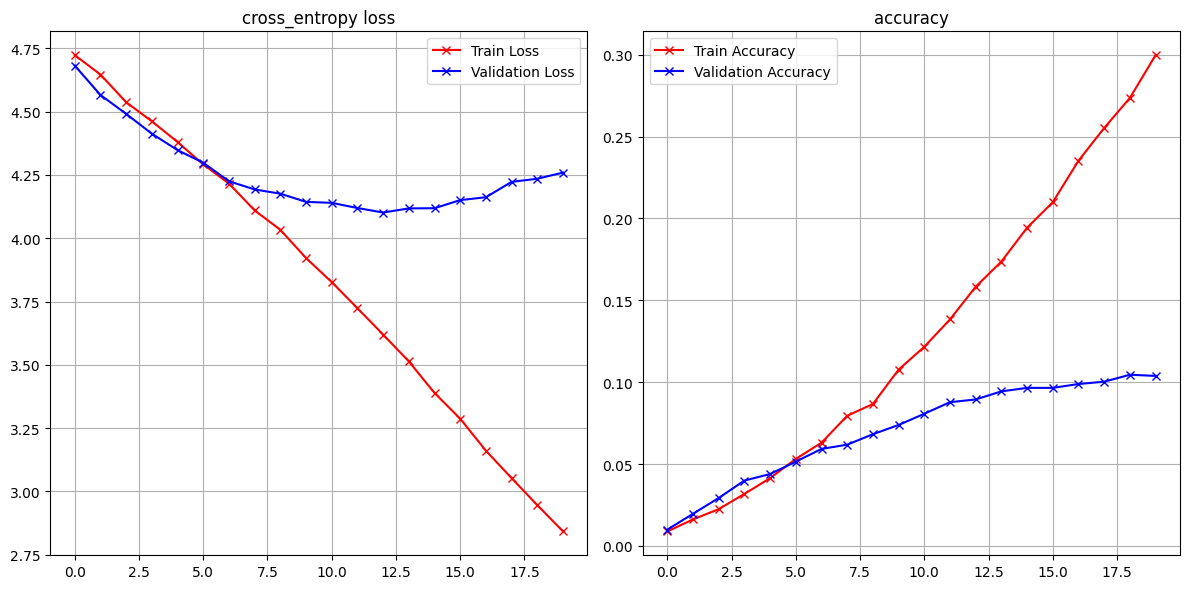

In [135]:
plot_loss_accuracy(history)